In [84]:
import os
import re
from typing import List, Dict, Union

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats, signal

from sklearn.metrics import mean_squared_error, r2_score


In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Загрузка данных

In [3]:
os.makedirs('data', exist_ok=True)

In [4]:
!unzip /content/ident_lab1.zip -d 'data'

Archive:  /content/ident_lab1.zip
  inflating: data/zad11_data.csv     
  inflating: data/zad12_data.csv     
  inflating: data/zad31_data.csv     
  inflating: data/zad22_data.csv     
  inflating: data/zad21_data.csv     
  inflating: data/zad32_data.csv     


In [5]:
DATA_DIR = '/content/data'

In [6]:
def load_data(
    task_number: int,
    data_dir = DATA_DIR,
) -> List[pd.DataFrame]:
    pattern = re.compile(rf'.*zad{task_number}\d_data\.csv')
    all_files = [os.path.join(data_dir, file_name) for file_name in os.listdir(data_dir) if file_name.endswith('.csv')]
    return [pd.read_csv(file_path) for file_path in all_files if pattern.match(file_path)]

# Задание 1

In [90]:
TASK_NUMBER = 1
df1, df2 = load_data(task_number=TASK_NUMBER)

In [91]:
display(df1.sample(5))
display(df2.sample(5))

,y,x1,x2,x3
525,-25.080131,3.423929,0.634979,5.227512
717,-65.176694,-2.743660,5.958935,12.590051
941,-83.880025,-0.603724,4.301102,14.722078
150,11.876557,2.878441,-1.467560,-1.206002
197,17.292351,3.341728,-0.624464,-1.260209


,y,x1,x2,x3
681,-67.921830,-3.484127,4.525321,11.518952
71,-4.246038,-1.722326,-2.016896,-0.722598
825,-100.354875,3.150197,3.779614,17.627505
580,-48.702531,1.186194,2.589355,8.879290
801,-87.218749,2.182323,6.510714,16.787559


In [92]:
X = df1.drop('y', axis=1)
y = df1['y']

In [47]:
np.linalg.det(X.T @ X)

np.float64(1806503003204.6038)

In [48]:
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta = theta.values.reshape(-1,1)

In [49]:
theta

array([[ 2.00453767],
       [ 3.83637446],
       [-6.73394495]])

In [50]:
y_approx = (X @ theta).values[:, 0]

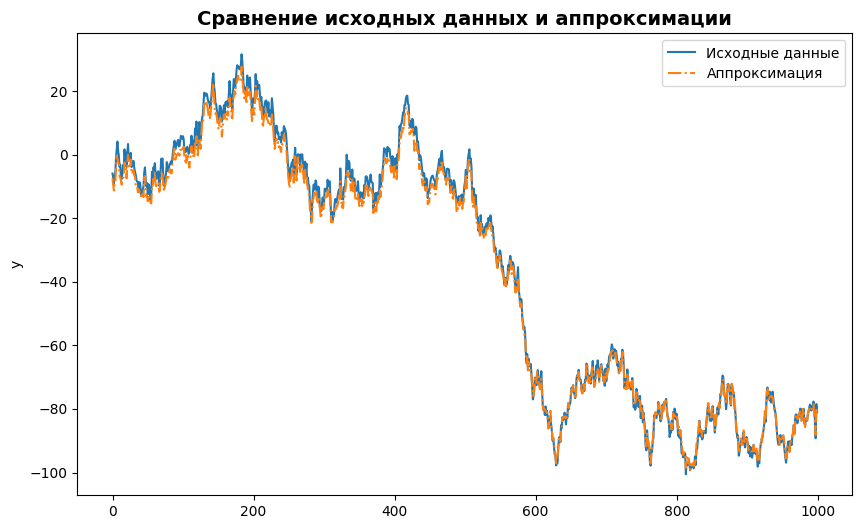

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df1.y, label='Исходные данные', ax=ax)
sns.lineplot(data=y_approx, label='Аппроксимация', ax=ax, linestyle='-.')
ax.legend()
ax.set_title('Сравнение исходных данных и аппроксимации',  fontsize=14, fontweight='bold')
plt.show()

In [52]:
err = df1.y - y_approx

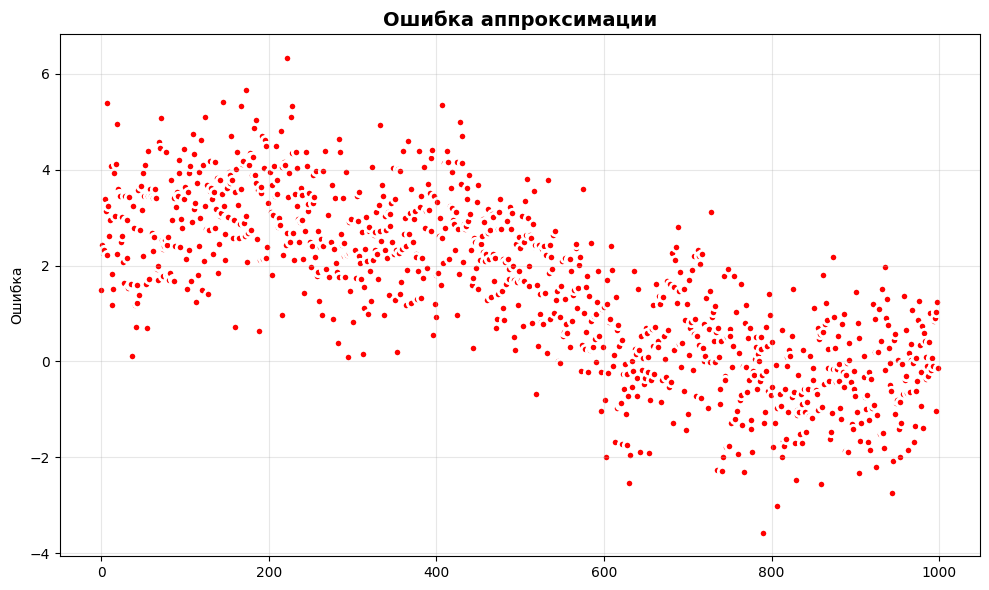

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(err, ax=ax, color='red', linewidth=2)
ax.set_title('Ошибка аппроксимации', fontsize=14, fontweight='bold')
ax.set_ylabel('Ошибка')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();


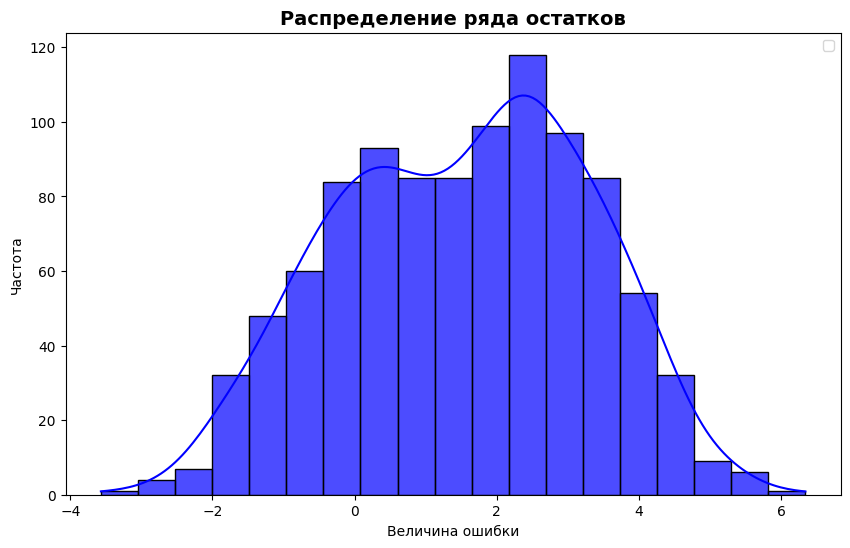

In [256]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(err, ax=ax, kde=True, color='blue', alpha=0.7)
ax.set_title('Распределение ряда остатков', fontsize=14, fontweight='bold')
ax.set_xlabel('Величина ошибки')
ax.set_ylabel('Частота')
ax.legend();

In [54]:
print(f"Среднее значение ряда остатков: {err.mean()}")
print(f"Стандартное отклонение ряда остатков: {err.std()}")

Среднее значение ряда остатков: 1.5182454363184452
Стандартное отклонение ряда остатков: 1.7583882624028468


### Гомоскедостичность (тест Бройша — Пагана)

In [258]:
X_const = sm.add_constant(X)
bp_test = sms.het_breuschpagan(err, X_const)
lm_stat, lm_pvalue, f_stat, f_pvalue = bp_test
print("p_value:", lm_pvalue)

p_value: 8.416991027002785e-95


мда, треш

Проверим еще и равенство среднего нулю (чтобы пойти на.. поиски другой модели)

In [259]:
t_stat, p_value = stats.ttest_1samp(err, popmean=0)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-значение: {p_value:.4f}")

t-статистика: 27.3041
p-значение: 0.0000


"радуемся" дважды


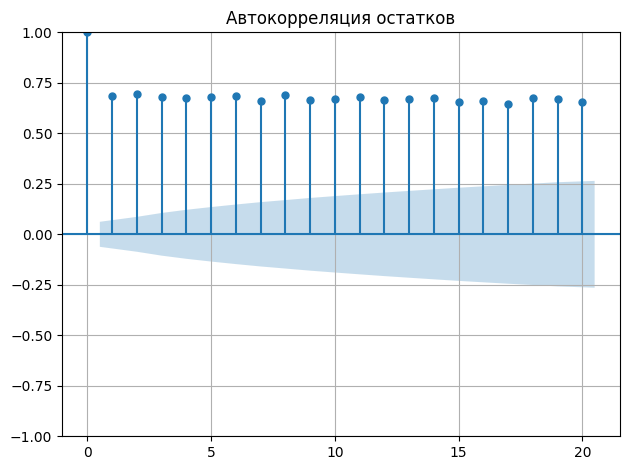

In [59]:
plot_acf(err, lags=20, alpha=0.05, title='Автокорреляция остатков')
plt.grid(True)
plt.tight_layout()
plt.show()

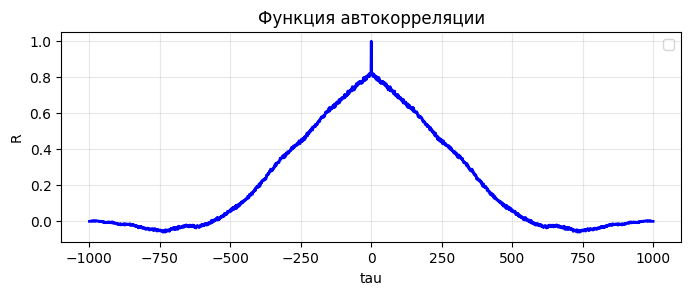

In [260]:
autocorr = signal.correlate(err, err, mode='full')
autocorr = autocorr / autocorr.max()

lags = signal.correlation_lags(len(err), len(err), mode='full')
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(lags, autocorr, 'b-', linewidth=2)
plt.xlabel('tau')
plt.ylabel('R')
plt.title('Функция автокорреляции')
plt.grid(True, alpha=0.3)
plt.legend();

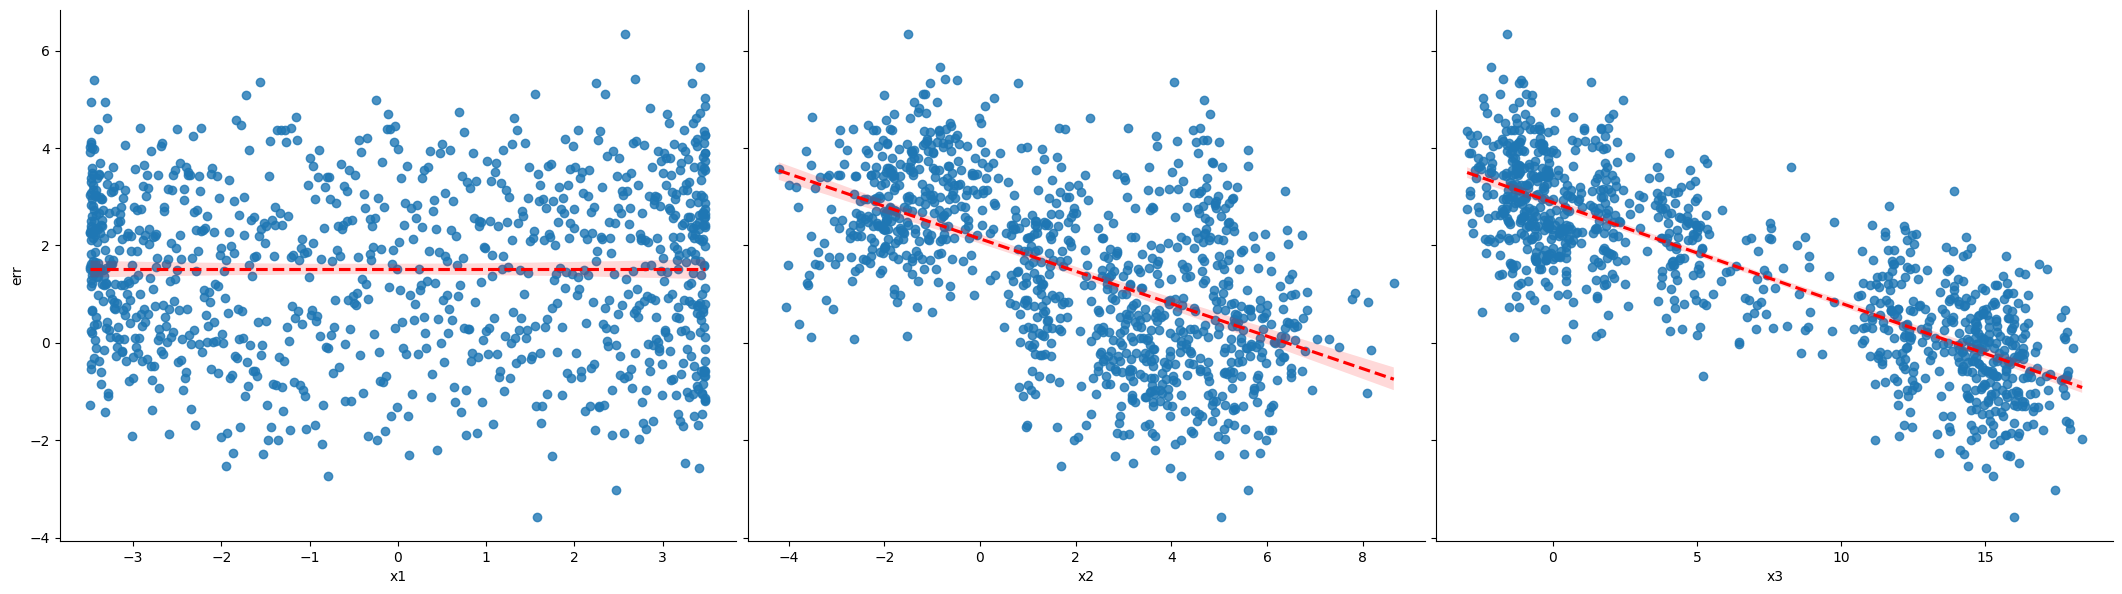

In [263]:
df_plot = X.copy()
df_plot['err'] = err

sns.pairplot(
    df_plot,
    y_vars=['err'],
    x_vars=X.columns,
    kind='reg',
    plot_kws={'line_kws': {'color': 'red', 'linestyle': '--'}},
    height=6,
    aspect=1.2
);

## Фикс

In [93]:
X_with_const = np.column_stack([np.ones(X.shape[0]), X])

In [94]:
theta = np.linalg.inv(X_with_const.T @ X_with_const) @ X_with_const.T @ y
theta = theta.reshape(-1, 1)
theta

array([[ 2.92768565],
       [ 2.02276442],
       [ 3.98654211],
       [-6.99017854]])

In [110]:
y_approx_fix = (X_with_const @ theta)[:, 0]

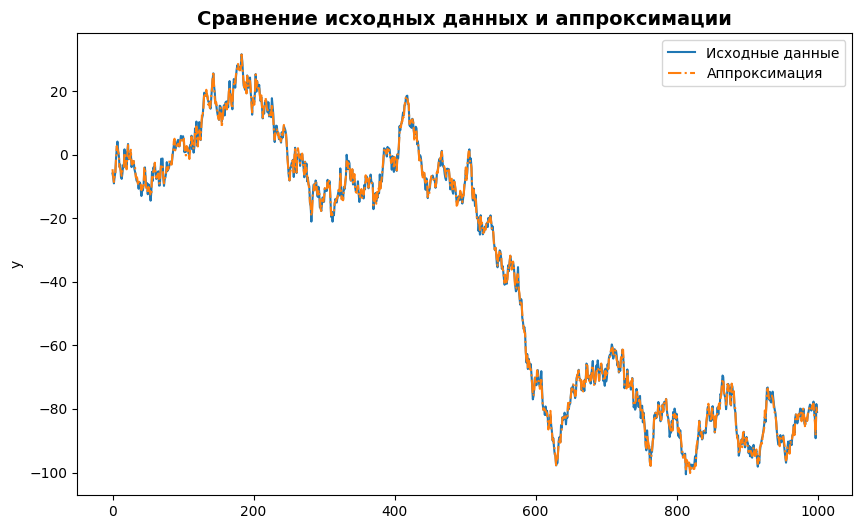

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df1.y, label='Исходные данные', ax=ax)
sns.lineplot(data=(y_approx_fix), label='Аппроксимация', ax=ax, linestyle='-.')
ax.legend()
ax.set_title('Сравнение исходных данных и аппроксимации',  fontsize=14, fontweight='bold')
plt.show()

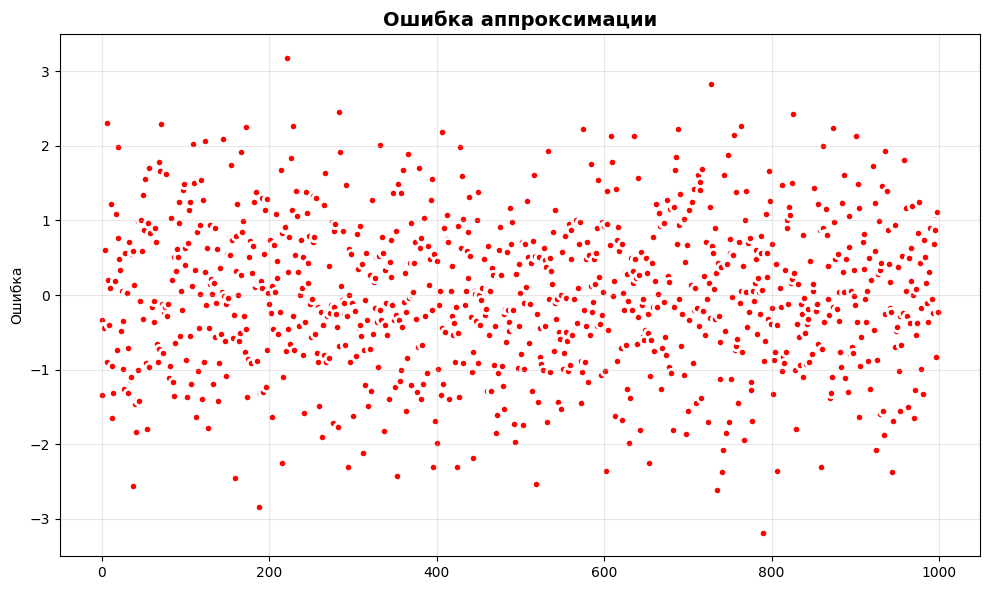

In [112]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(df1.y - y_approx_fix, ax=ax, color='red', linewidth=2)
ax.set_title('Ошибка аппроксимации', fontsize=14, fontweight='bold')
ax.set_ylabel('Ошибка')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();


## df2

In [60]:
X = df2.drop('y', axis=1)
y = df2['y']

theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta = theta.values.reshape(-1,1)

y_approx = (X @ theta).values[:, 0]

err = df1.y - y_approx

In [61]:
print(theta)

[[ 2.02321462]
 [ 3.99025128]
 [-6.99650756]]


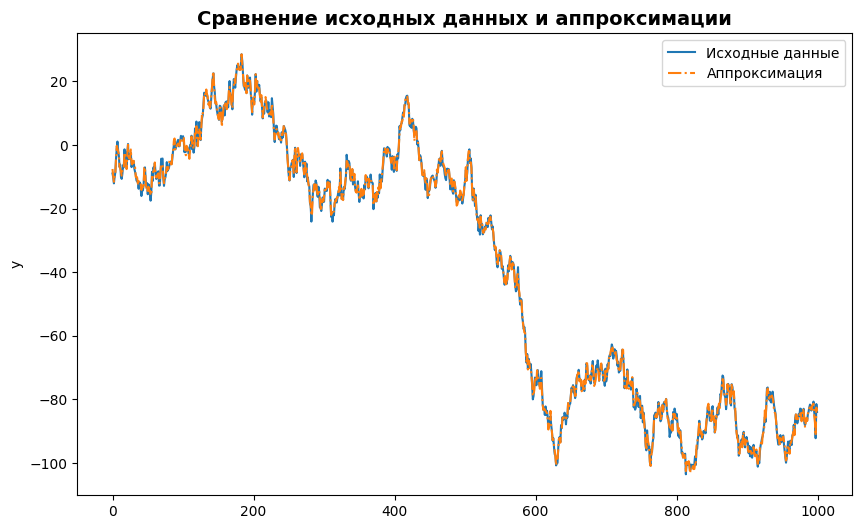

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df2.y, label='Исходные данные', ax=ax)
sns.lineplot(data=y_approx, label='Аппроксимация', ax=ax, linestyle='-.')
ax.legend()
ax.set_title('Сравнение исходных данных и аппроксимации',  fontsize=14, fontweight='bold')
plt.show()

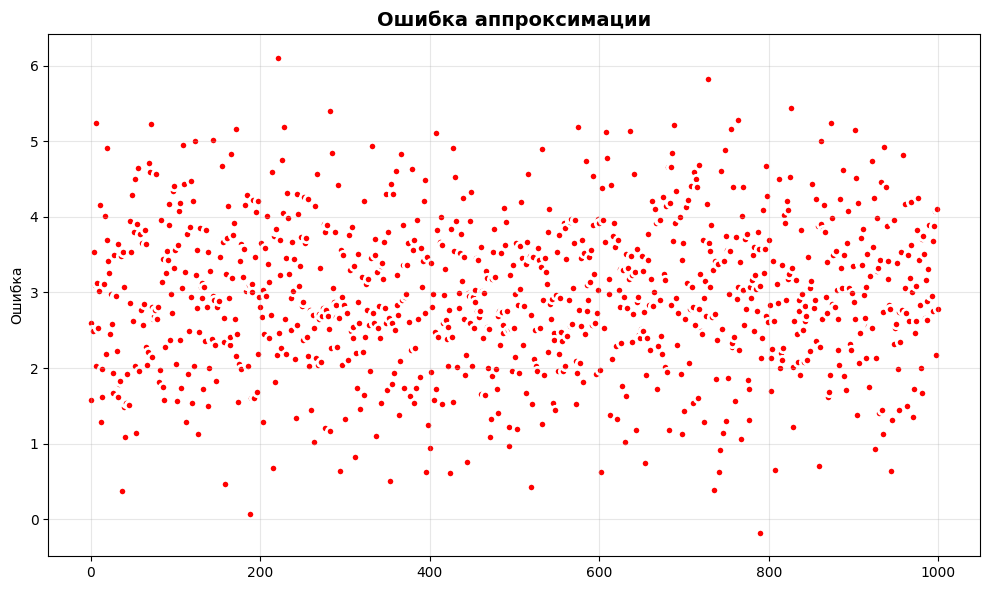

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(err, ax=ax, color='red', linewidth=2)
ax.set_title('Ошибка аппроксимации', fontsize=14, fontweight='bold')
ax.set_ylabel('Ошибка')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();


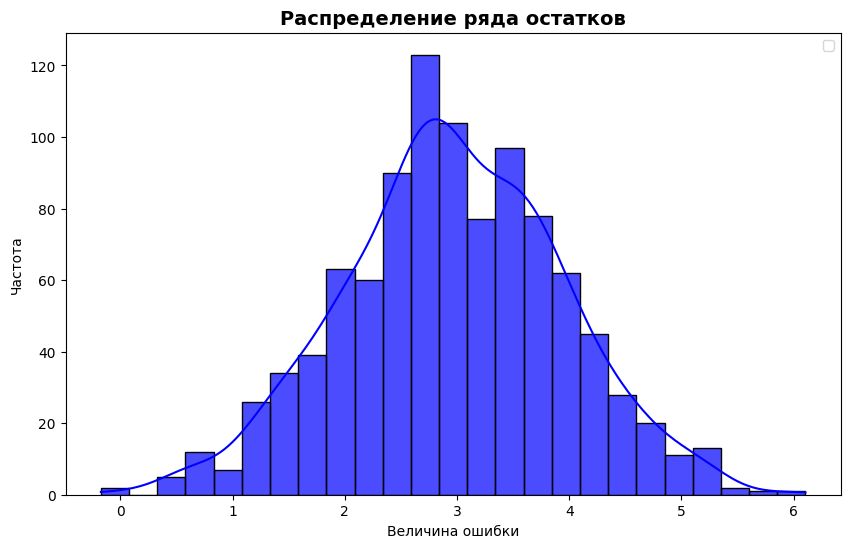

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(err, ax=ax, kde=True, color='blue', alpha=0.7)
ax.set_title('Распределение ряда остатков', fontsize=14, fontweight='bold')
ax.set_xlabel('Величина ошибки')
ax.set_ylabel('Частота')
ax.legend();

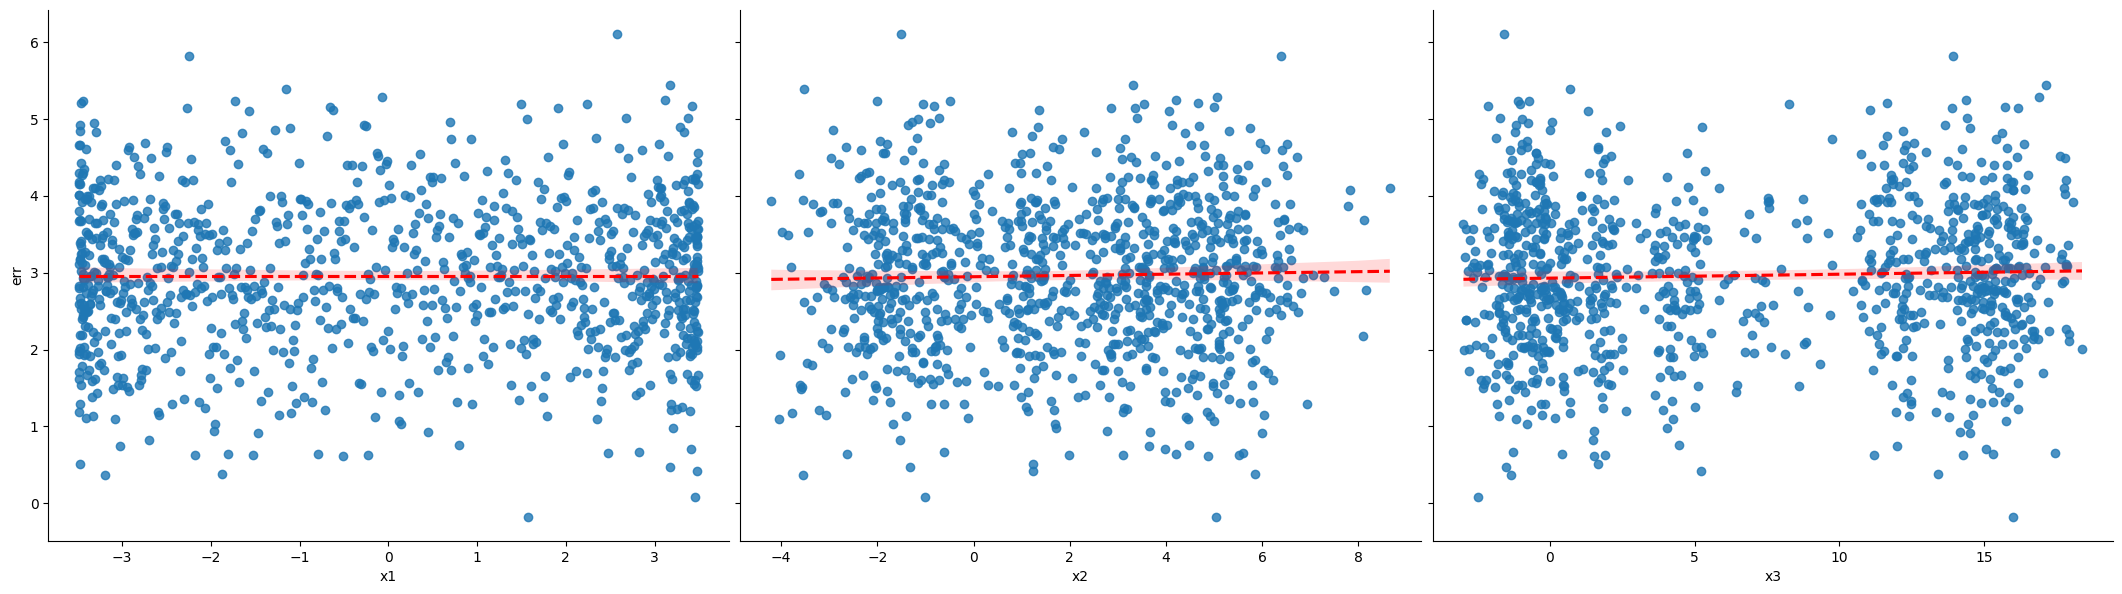

In [70]:
df_plot = X.copy()
df_plot['err'] = err
sns.pairplot(
    df_plot,
    y_vars=['err'],
    x_vars=X.columns,
    kind='reg',
    plot_kws={'line_kws': {'color': 'red', 'linestyle': '--'}},
    height=6,
    aspect=1.2
);

In [65]:
X_const = sm.add_constant(X)
bp_test = sms.het_breuschpagan(err, X_const)
lm_stat, lm_pvalue, f_stat, f_pvalue = bp_test
print("p_value:", lm_pvalue)

p_value: 0.7160978863293954


In [66]:
t_stat, p_value = stats.ttest_1samp(err, popmean=0)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-значение: {p_value:.4f}")

t-статистика: 96.0546
p-значение: 0.0000


In [67]:
print(f"Среднее значение ряда остатков: {err.mean()}")
print(f"Стандартное отклонение ряда остатков: {err.std()}")

Среднее значение ряда остатков: 2.962499071627579
Стандартное отклонение ряда остатков: 0.9753040200067221


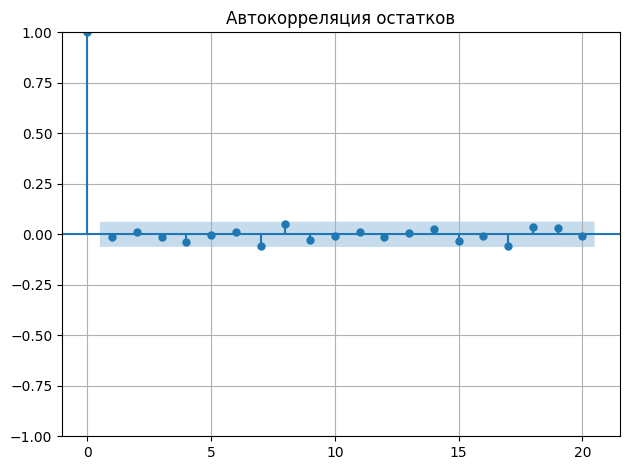

In [68]:
plot_acf(err, lags=20, alpha=0.05, title='Автокорреляция остатков')
plt.grid(True)
plt.tight_layout()
plt.show()

# Задание 2

In [72]:
TASK_NUMBER = 2
df1, df2 = load_data(task_number=TASK_NUMBER)

In [73]:
display(df1.head())
display(df2.head())

,T,V
0,30,531.767737
1,33,587.112325
2,36,669.371415
3,39,732.729632
4,42,815.565439


,T,V
0,30,538.502677
1,33,600.661288
2,36,648.747125
3,39,704.990949
4,42,746.370337


In [75]:
T = df1['T'].values.reshape(-1, 1)
V = df1['V'].values

lin_reg = model = Lasso(alpha=1.0)
lin_reg.fit(T, V)
V_pred_H1 = lin_reg.predict(T)

b_H1 = lin_reg.coef_[0]
c_H1 = lin_reg.intercept_

lin_approx_err = df1['V'] - V_pred_H1

In [76]:
T_poly = np.hstack([T**2, T])
quad_reg = LinearRegression()
quad_reg.fit(T_poly, V)
V_pred_H2 = quad_reg.predict(T_poly)

a_H2 = quad_reg.coef_[0]
b_H2 = quad_reg.coef_[1]
c_H2 = quad_reg.intercept_

In [77]:
MSE_H1 = mean_squared_error(V, V_pred_H1)
MSE_H2 = mean_squared_error(V, V_pred_H2)

R2_H1 = r2_score(V, V_pred_H1)
R2_H2 = r2_score(V, V_pred_H2)

print(f"H1: V = {b_H1:.4f} * T + {c_H1:.4f}")
print(f"MSE для H1: {MSE_H1:.6f}, R2 для H1: {R2_H1:.6f}")


print(f"H2: V = {a_H2:.4f} * T^2 + {b_H2:.4f} * T + {c_H2:.4f}")
print(f"MSE для H2: {MSE_H2:.6f}, R2 для H2: {R2_H2:.6f}")

H1: V = 17.5341 * T + 48.0936
MSE для H1: 932.874557, R2 для H1: 0.979690
H2: V = -0.2262 * T^2 + 39.9387 * T + -473.5022
MSE для H2: 70.509294, R2 для H2: 0.998465


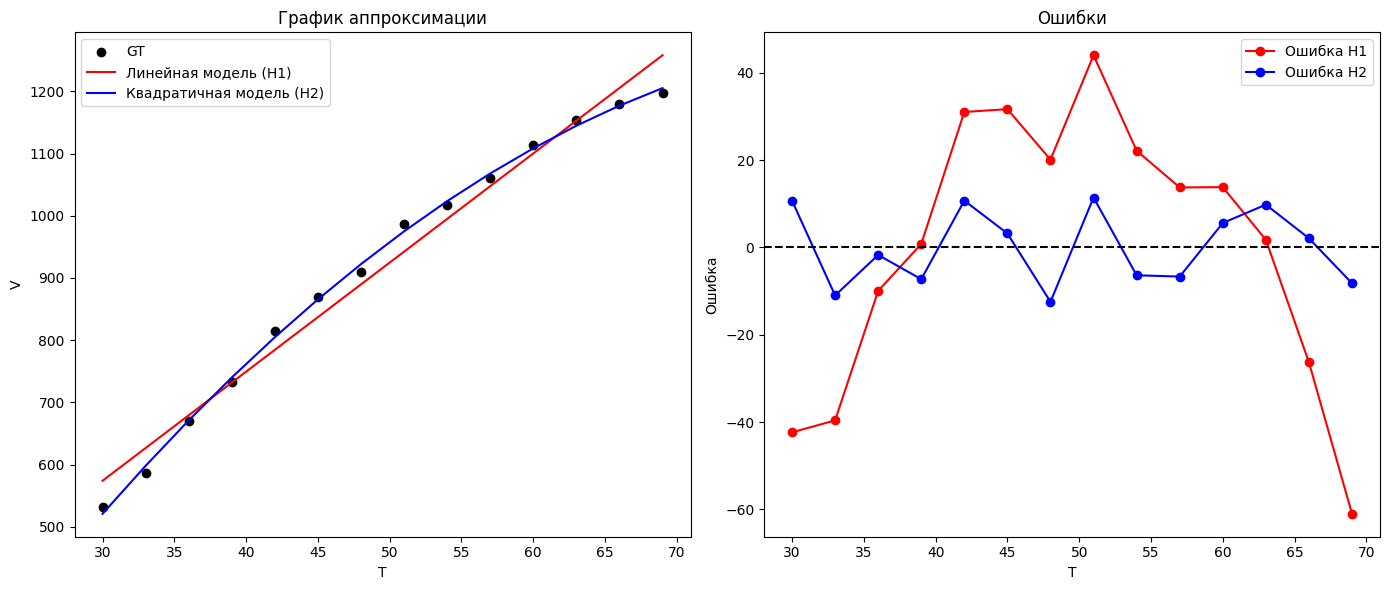

In [78]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(T, V, label='GT', color='black')
plt.plot(T, V_pred_H1, label='Линейная модель (H1)', color='red')
plt.plot(T, V_pred_H2, label='Квадратичная модель (H2)', color='blue')
plt.xlabel('T')
plt.ylabel('V')
plt.title('График аппроксимации')
plt.legend()

plt.subplot(1,2,2)
plt.plot(T, V - V_pred_H1, 'r-o', label='Ошибка H1')
plt.plot(T, V - V_pred_H2, 'b-o', label='Ошибка H2')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('T')
plt.ylabel('Ошибка')
plt.title('Ошибки')
plt.legend()

plt.tight_layout()
plt.show()


## df2

In [80]:
T = df2['T'].values.reshape(-1, 1)
V = df2['V'].values

lin_reg = model = Lasso(alpha=1.0)
lin_reg.fit(T, V)
V_pred_H1 = lin_reg.predict(T)

b_H1 = lin_reg.coef_[0]
c_H1 = lin_reg.intercept_

lin_approx_err = df1['V'] - V_pred_H1

In [81]:
T_poly = np.hstack([T**2, T])
quad_reg = LinearRegression()
quad_reg.fit(T_poly, V)
V_pred_H2 = quad_reg.predict(T_poly)

a_H2 = quad_reg.coef_[0]
b_H2 = quad_reg.coef_[1]
c_H2 = quad_reg.intercept_

In [82]:
MSE_H1 = mean_squared_error(V, V_pred_H1)
MSE_H2 = mean_squared_error(V, V_pred_H2)

R2_H1 = r2_score(V, V_pred_H1)
R2_H2 = r2_score(V, V_pred_H2)

print(f"H1: V = {b_H1:.4f} * T + {c_H1:.4f}")
print(f"MSE для H1: {MSE_H1:.6f}, R2 для H1: {R2_H1:.6f}")


print(f"H2: V = {a_H2:.4f} * T^2 + {b_H2:.4f} * T + {c_H2:.4f}")
print(f"MSE для H2: {MSE_H2:.6f}, R2 для H2: {R2_H2:.6f}")

H1: V = 17.9052 * T + 5.2476
MSE для H1: 32.624141, R2 для H1: 0.999305
H2: V = -0.0083 * T^2 + 18.7322 * T + -14.1796
MSE для H2: 31.460821, R2 для H2: 0.999330


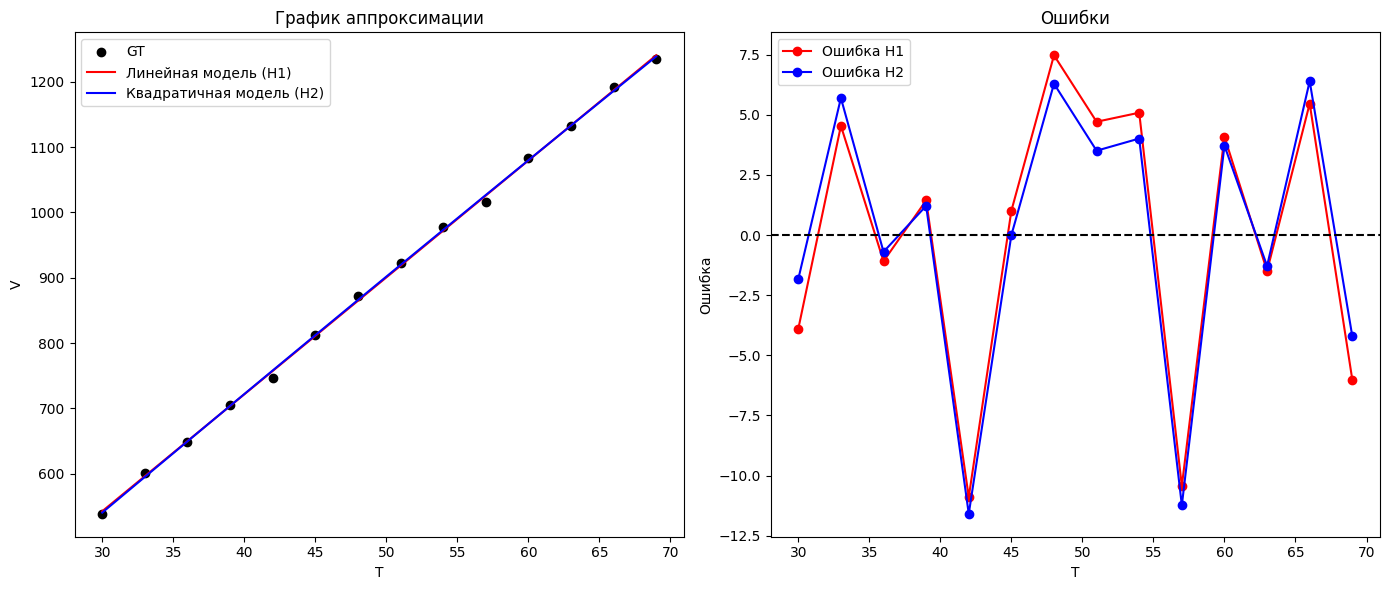

In [83]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(T, V, label='GT', color='black')
plt.plot(T, V_pred_H1, label='Линейная модель (H1)', color='red')
plt.plot(T, V_pred_H2, label='Квадратичная модель (H2)', color='blue')
plt.xlabel('T')
plt.ylabel('V')
plt.title('График аппроксимации')
plt.legend()

plt.subplot(1,2,2)
plt.plot(T, V - V_pred_H1, 'r-o', label='Ошибка H1')
plt.plot(T, V - V_pred_H2, 'b-o', label='Ошибка H2')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('T')
plt.ylabel('Ошибка')
plt.title('Ошибки')
plt.legend()

plt.tight_layout()
plt.show()
